In [1]:
%%html
<style>
table {float:left}
</style>

# <font color="darkgray">Quantum Reservoir Computing</font><br>Workshop Version

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To create and use a quantum reservoir computing model in <strong>PennyLane</strong>.<br>
            Compare this quantum reservoir with the equivalent classical reservoir.</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the the Mackey-Glass time series generator (code included)</td></tr>
    <tr><td><strong>Timeframe:</strong></td>
        <td>01/07/25-26/09/25 (possible extensions)</td></tr>
    <tr><td><strong>References:</strong></td>
        <td><ul>
            <li><a href = "https://doi.org/10.1103/PhysRevApplied.14.024065" target="_blank">
                Chen, J., Nurdin, H.I., Yamamoto, N., 2020. Temporal Information Processing on Noisy Quantum Computers. Phys. Rev. Applied 14, 024065.
</a></li>
            <li><a href = "https://doi.org/10.1088/2634-4386/ac7db7" target="_blank">Cucchi, M., Abreu, S., Ciccone, G., Brunner, D., Kleemann, H., 2022. Hands-on reservoir computing: a tutorial for practical implementation. Neuromorph. Comput. Eng. 2, 032002. 
</a></li>
            <li><a href = "https://doi.org/10.1038/s41467-021-25801-2" target="_blank">Gauthier, D.J., Bollt, E., Griffith, A., Barbosa, W.A.S., 2021. Next generation reservoir computing. Nat Commun 12, 5564.
</a></li>
        </ul></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="./LICENSE" target="_blank">GNU General Public License V3</a></td></tr>
</table>

### Quantum reservoir computing (QRC)
QRC is a quantum approach to the creation of Reservoir Computing, which is a concepts derived from recurrent neural networks (RNN). 
It can be applied to all types of data, however, it is especially useful for temporal data. 
Reservoir computing utilises a large sparse neural network of randomly initialised and fixed weights (_**reservoir**_),
responsible for transforming input into a higher-dimensional space.
In high-dimensional space, data can be easily separated  (_**classified**_) by using a simple linear model (_**readout layer**_),
such a ridge regression.
The _**reservoir dynamics**_ can be specified by a set of differential equations (_**update rules**_)
responsible for describing changes to the reservoir state over time.

Typical reservoir computing applications include: time-series forecasting, speech recognition and video analysis, control of robots or autonomous vehicles, as well as, predicting weather patterns and stock markets.

## <font color="blue">Data preparation</font>
<font color="CornflowerBlue">In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).</font>

### Prepare synthetic time series data

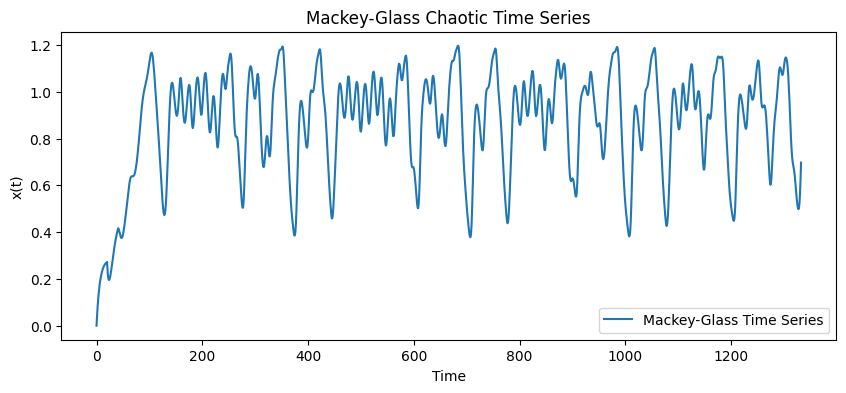

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
# time_series = mackey_glass(dt=1, T=2000)
time_series = mackey_glass(beta=0.17, dt=1.5, T=2000, tau=30)

plt.figure(figsize=(10, 4))
plt.plot(time_series, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

### Prepare trainig and testing data partitions

In [3]:
### Prepare the data
def create_io_pairs(data, window_size):
    """
    Create input-output pairs for training/testing.
    """
    inputs = []
    outputs = []
    for i in range(len(data) - window_size):
        inputs.append(data[i:i + window_size])
        outputs.append(data[i + window_size])
    return np.array(inputs), np.array(outputs)

### Data settings
window_size = 10  # Use the last 10 time steps to predict the next step
train_size = 1000  # Use the first 1000 points for training
test_size = 500   # Use the next 500 points for testing

### Create data
train_inputs, train_outputs = create_io_pairs(time_series[:train_size], window_size)
test_inputs, test_outputs = create_io_pairs(time_series[train_size:train_size + test_size], window_size)

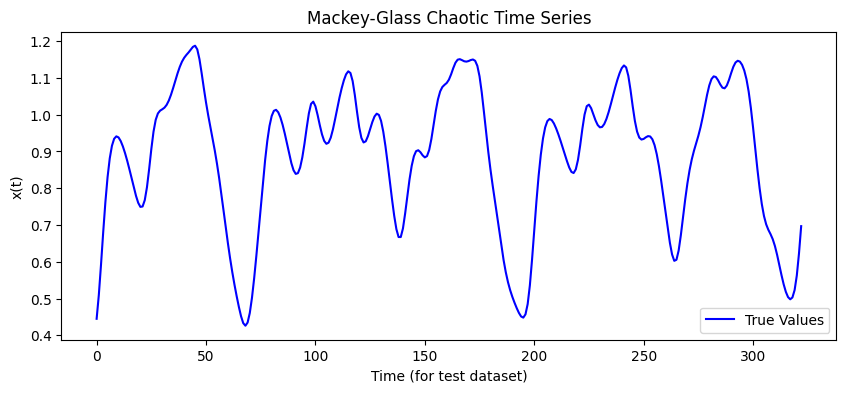

In [4]:
### Plot the test set
plt.figure(figsize=(10, 4))
plt.plot(test_outputs, label="True Values", color="blue")
plt.xlabel('Time (for test dataset)')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

## <font color="blue">Model development</font>

In [5]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

### Quantum reservoir hyper-parameters

In [6]:
n_qubits = 4  # Number of qubits in the reservoir
n_layers = 2  # Number of layers in the quantum circuit

### Quantum device to use
dev = qml.device("default.qubit", wires=n_qubits)

### Create and initialize the reservoir
*This includes its function and a circuit*

In [7]:
### Leakage in input only
def quantum_reservoir(inputs, weights, biases, leakage_rate=0.1, previous_state=None):
    """
    inputs: Current input vector
    previous_state: Classical reservoir state from previous timestep (array of expectations)
    leakage_rate (α): Controls memory retention
    """
    n_observables = 3 * n_qubits  # X,Y,Z for each qubit
    
    # Initialize previous state if first run
    if previous_state is None:
        previous_state = np.zeros(n_observables)
    
    # Encode mixed state: (1-α)*previous + α*new_input
    for i in range(n_qubits):
        # Encode input with leakage
        input_component = leakage_rate * (inputs[i % len(inputs)] + biases[i])
        
        # Encode memory from previous state
        memory_component = (1 - leakage_rate) * previous_state[i] 
        
        # Apply combined rotation
        total_angle = input_component + memory_component
        qml.RX(total_angle, wires=i)
    
    # Reservoir dynamics (fixed weights)
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.Rot(*weights[layer, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    
    # Return current observables
    return [qml.expval(qml.PauliX(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliY(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Quantum node to measure all Pauli observables
@qml.qnode(dev)
def reservoir_circuit(inputs, weights, biases, leakage_rate=0.1, previous_state=None):
    return quantum_reservoir(inputs, weights, biases, leakage_rate, previous_state)

### Train the reservoir
*Includes the readout layer.*

In [8]:
def train_reservoir(train_inputs, train_outputs, n_layers, n_qubits, leakage_rate=0.1, lambda_reg=1e-6, n_epochs=1):
    """
    Trains a quantum reservoir with proper state management across epochs.
    
    Args:
        train_inputs: List of input sequences (each shape [window_size])
        train_outputs: Target values (shape [n_samples])
        n_layers: Number of reservoir layers
        n_qubits: Number of qubits
        leakage_rate: γ ∈ (0,1] for fading memory
        lambda_reg: Ridge regression parameter
        n_epochs: Passes through training data / 
            not relevant with the state vector simulator 
        
    Returns:
        W_out: Readout weights (shape [3*n_qubits])
        weights: Reservoir weights (shape [n_layers, n_qubits, 3])
        biases: Input biases (shape [n_qubits])
    """
    # Initialize parameters
    weights = np.random.uniform(-np.pi, np.pi, (n_layers, n_qubits, 3))
    biases = np.random.uniform(-0.5, 0.5, n_qubits)
    n_observables = 3 * n_qubits
    
    # For multiple epochs, we'll average the states
    all_epoch_states = []
    
    for epoch in range(n_epochs):
        epoch_states = []
        prev_state = np.zeros(n_observables)  # Reset state at epoch start
        
        for input_seq in train_inputs:
            current_state = reservoir_circuit(
                inputs=input_seq,
                weights=weights,
                biases=biases,
                leakage_rate=leakage_rate,
                previous_state=prev_state
            )
            epoch_states.append(current_state)
            prev_state = current_state
        
        all_epoch_states.append(np.vstack(epoch_states))
    
    # Average states across epochs if n_epochs > 1
    R = np.mean(all_epoch_states, axis=0) if n_epochs > 1 else all_epoch_states[0]
    Y = train_outputs.reshape(-1, 1)
    
    # Ridge regression
    I = np.eye(n_observables)
    W_out = np.linalg.solve(R.T @ R + lambda_reg * I, R.T @ Y).flatten()
    
    return W_out, weights, biases

### Predict the output from inputs

In [9]:
def predict(test_inputs, weights, biases, W_out, leakage_rate=0.1):
    predictions = []
    prev_state = np.zeros(3 * n_qubits)
    
    for input_seq in test_inputs:
        # Get state with memory
        current_state = reservoir_circuit(
            input_seq, weights, biases, leakage_rate, prev_state
        )
        # Predict and update memory
        y_pred = np.dot(W_out, current_state)
        predictions.append(y_pred)
        prev_state = current_state
    
    return np.array(predictions)

### Testing

In [10]:
# For reproducibility
np.random.seed(2025)
    
W_out, weights, biases = train_reservoir(
    train_inputs, 
    train_outputs, 
    n_layers=n_layers, 
    n_qubits=n_qubits,
    leakage_rate=0.1,
    lambda_reg=1e-5
)

test_preds = predict(test_inputs, weights, biases, W_out)
mse = np.mean((test_preds - test_outputs)**2)

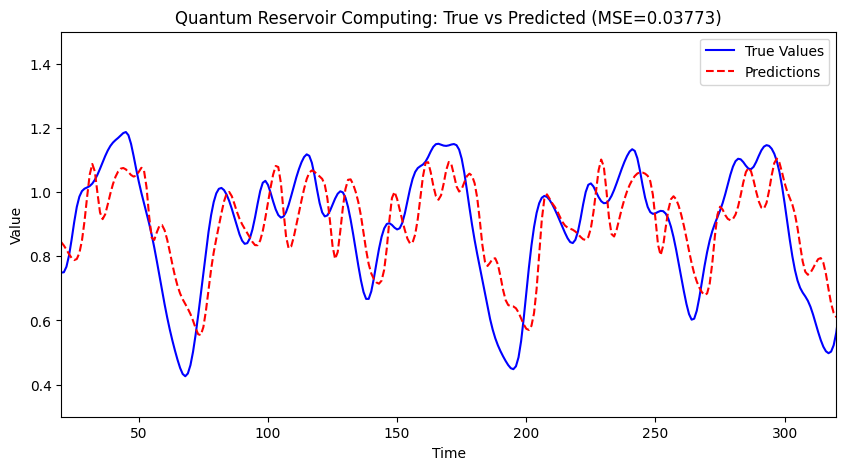

In [11]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label="Predictions", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Value")
plt.xlim(20, 320)
plt.ylim(0.3, 1.5)
plt.title(f'Quantum Reservoir Computing: True vs Predicted (MSE={np.round(mse, 5)})')
plt.legend()
plt.show()

### Experimenting with leakage

In [12]:
# Train with different leakage rates to find the optimum
leakage_rates = [0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
mse_scores = []
best_mse = float(np.inf)
best_params = None

# For reproducibility
np.random.seed(42)
    
for rate in leakage_rates:
    W_out, weights, biases = train_reservoir(
        train_inputs, train_outputs, n_layers, n_qubits, leakage_rate=rate)
    test_preds = predict(test_inputs, weights, biases, W_out, leakage_rate=rate)
    current_mse = np.mean((test_outputs - test_preds)**2)
    mse_scores.append(current_mse)
    current_params = (W_out, weights, biases, rate, current_mse)
    print(f'Tested leakage rate: {rate}, mse: {np.round(current_mse, 5)}')
    
    if current_mse < best_mse:
        best_mse = current_mse
        best_params = current_params

Tested leakage rate: 0.01, mse: 0.03389
Tested leakage rate: 0.03, mse: 0.06569
Tested leakage rate: 0.05, mse: 0.03063
Tested leakage rate: 0.07, mse: 0.08912
Tested leakage rate: 0.1, mse: 0.08515
Tested leakage rate: 0.3, mse: 0.01777
Tested leakage rate: 0.5, mse: 0.01645
Tested leakage rate: 0.7, mse: 0.52506
Tested leakage rate: 0.9, mse: 0.01141
Tested leakage rate: 0.95, mse: 0.01258
Tested leakage rate: 0.99, mse: 0.00996


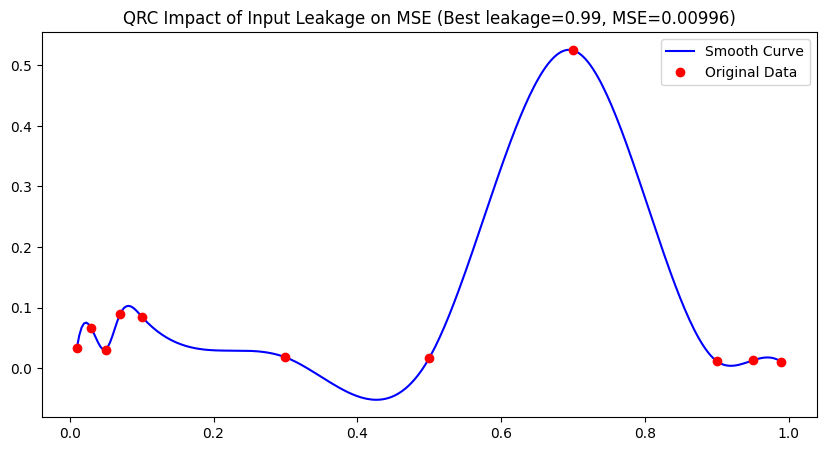

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Example data
X = np.array(leakage_rates)
y = np.array(mse_scores)
best_rate = best_params[3]

# Generate smooth curve using spline interpolation
X_smooth = np.linspace(X.min(), X.max(), 300)  # 300 points for smoothness
spline = make_interp_spline(X, y, k=3)  # Cubic spline (k=3)
y_smooth = spline(X_smooth)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X_smooth, y_smooth, '-', color="blue", label="Smooth Curve")  # Smoothed line
plt.plot(X, y, 'o', color="red", label="Original Data")  # Original points
plt.title(f'QRC Impact of Input Leakage on MSE (Best leakage={best_rate}, MSE={np.round(best_mse, 5)})')
plt.legend()
plt.show()

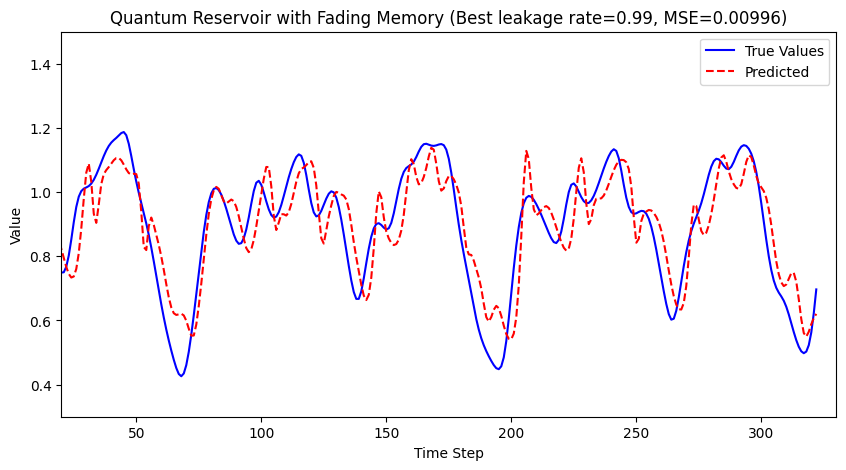

In [14]:
# Use best parameters for final prediction
W_out, weights, biases, best_rate, best_mse = best_params
plt.figure(figsize=(10, 5))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label=f"Predicted", color="red", linestyle="--")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.xlim(20, 330)
plt.ylim(0.3, 1.5)
plt.title(f'Quantum Reservoir with Fading Memory (Best leakage rate={best_rate}, MSE={np.round(best_mse, 5)})')
plt.legend()
plt.show()

## Write your observations here

- Observation 1:
- Observation 2:
- Observation 3:
- Observation 4:
- Observation 5:
- Observation 6:
- Observation 7:


# Software in use (Linux)

In [15]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
PennyLane-Rigetti         0.40.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
